In [1]:
# autoreload notebook to update changes to imported packages
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext watermark
%watermark -a "Kenneth Brezinski" -v

Author: Kenneth Brezinski

Python implementation: CPython
Python version       : 3.9.10
IPython version      : 8.0.1



In [3]:
import torch

from torchvision.datasets import FashionMNIST
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt

%watermark --iversions

C:\Users\Jamie\anaconda3\envs\py39\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\Jamie\anaconda3\envs\py39\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


torchvision: 0.11.3+cu102
torch      : 1.10.2+cu102
matplotlib : 3.5.1



In [4]:
train_ds = FashionMNIST("data", transform=transforms.ToTensor(), train=True, download=True)
valid_ds = FashionMNIST("data", transform=transforms.ToTensor(), train=False, download=True)

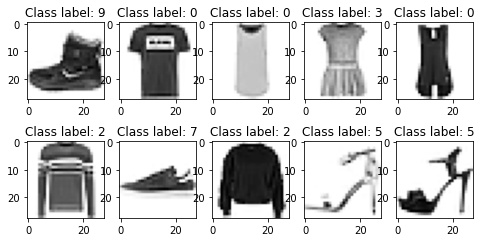

In [5]:
plt.figure(figsize=(8,4))
ds_iterable = iter(train_ds)

# Checking the first 10 elements of the dataset
for i in range(10):
    img, label = next(ds_iterable)
    plt.subplot(2, 5, i+1)
    plt.imshow(img[0], 'Greys')
    plt.title(f"Class label: {label}")

In [6]:
batch_size = 256

train_loader = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=batch_size, shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])


In [39]:
class SimpleMLP(torch.nn.Module):
    
    def __init__(self, features_per_layer, weight_init='he', bias=True): 
        super().__init__()
        
        layers = [torch.nn.Flatten(start_dim=1)]
        
        for d_in, d_out in zip(features_per_layer[:-1], features_per_layer[1:]):
            layers.append(torch.nn.Linear(d_in, d_out, bias=True))
            layers.append(torch.nn.ReLU())
            
        layers.append(torch.nn.Linear(d_out, 10, bias=True))  
        self.model = torch.nn.Sequential(*layers)
        
        self.weight_init = torch.nn.init.kaiming_uniform_
        self._init_weights()

        
    def _init_weights(self):
        
        for m in self.modules():
            if isinstance(m, torch.nn.Linear):
                self.weight_init(m.weight, mode='fan_in')  
                
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            
             
    def forward(self, x):
        return self.model(x)
    
    
def fetch_learnables(model, writer, epoch):
    for i, layer in enumerate(model.model):
        if isinstance(layer, torch.nn.Linear):
            writer.add_histogram(f"layer_{i}_weight", layer.weight)
            writer.add_histogram(f"layer_{i}_bias", layer.bias)

In [40]:
params = dict(epochs=5,
              arch=[28*28, 64, 32],
              weight_init=None,
              lr=1e-2,
              verbose=False,
              logs_per_epoch=2,
              writer=True
              )

model = SimpleMLP(features_per_layer=params['arch'])
optimizer = torch.optim.SGD(model.parameters(), lr=params['lr'])
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
criterion = lambda pred, y: (pred == y).sum().item() / len(y)

iteration_name = f"lr={params['lr']}_arch={'-'.join(str(c) for c in params['arch'])}"
writers = {'train': SummaryWriter(f'runs/train_' + iteration_name),
           'valid': SummaryWriter(f'runs/valid_' + iteration_name)}

def train_model(train_loader, valid_loader, params, writers):
    
    for epoch in range(params['epochs']):
        model.train()
        # run training loop
        for batch_idx, (img, label) in enumerate(train_loader):
            output = model(img)
            loss = loss_fn(output, label)
            
            class_pred = torch.argmax(output, dim=-1)
            accuracy = criterion(class_pred, label)

            optimizer.zero_grad()
            loss.backward() 
            optimizer.step() 
            
            if params['writer']:
                writers['train'].add_scalar('acc', accuracy, epoch+1)
                writers['train'].add_scalar('loss', loss.item(), epoch+1)
                
                fetch_learnables(model, writers['train'], epoch+1)
                
                      
            if params['verbose']:
                if not batch_idx % (len(train_loader) // params['logs_per_epoch']):
                    print(f"[Epoch {epoch+1:03d}][Batch {batch_idx:03d}/{len(train_loader)}]"
                          f"[Loss {loss.item():.4f}][Acc {accuracy:.4f}]")
                
        # run validation
        with torch.no_grad():
            model.eval()
            # run validation loop
            for batch_idx, (img, label) in enumerate(valid_loader):
                output = model(img)
                loss = loss_fn(output, label)

                class_pred = torch.argmax(output, dim=-1)
                accuracy = criterion(class_pred, label)        
                
                if params['writer']:
                    writers['valid'].add_scalar('acc', accuracy, epoch+1)
                    writers['valid'].add_scalar('loss', loss.item(), epoch+1)       
                
                if params['verbose']:
                    if not batch_idx % (len(valid_loader) // params['logs_per_epoch']):
                        print(f"[Epoch {epoch+1:03d}][Batch {batch_idx:03d}/{len(valid_loader)}]"
                              f"[Loss {loss.item():.4f}][Acc {accuracy:.4f}]")
                    print("*" * 60)
                    
        print(f"Finished Epoch {epoch+1:02d}/{params['epochs']:02d}")
        
    writers['train'].add_graph(model, img)
    writers['train'].close()
    writers['valid'].close()
                     
                             
train_model(train_loader, valid_loader, params, writers)

Finished Epoch 01/05
Finished Epoch 02/05
Finished Epoch 03/05
Finished Epoch 04/05
Finished Epoch 05/05


KeyError: 'test'